# Proof of concept

In [1]:
import pickle
import glob
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from scipy.spatial import distance
import uuid
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
from mc_moea import *
pandarallel.initialize(progress_bar=False, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
import gc

### Generate small position data

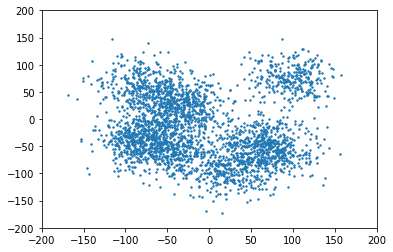

In [20]:
n_clusters = 10
X, y = make_blobs(n_samples=3000, cluster_std=25, centers=n_clusters, n_features=2, center_box=(-100.0, 100.0))
plt.scatter(X[:,0], X[:,1], s=2)
plt.xlim((-200,200))
plt.ylim((-200,200))
plt.show()

In [21]:
pickle.dump(X, open("poc_position-2.pkl", "wb"))

In [4]:
position_df = pickle.load(open("poc_position-2.pkl", "rb"))

In [5]:
position_df.shape

(3000, 2)

### Stations

In [6]:
station_types = station_types.iloc[-1:]

In [7]:
station_types

,types,frequency,capacity,cost
5,2600 MHz Type II,2600,1300,1350000


In [23]:
s_info = station_types.iloc[-1]

### Simulation parameters

In [6]:
max_station = 5
n_population = 300
crossover_p = 0.3
mutation_p = 0.1
elitism_ratio = 0.5
trim_policy = "best"  # "random" or "best"
num_iters = 400
checkpoint_every = 1

### Initial population

In [11]:
# stations_l = [generate_station(n) for n in np.random.randint(1,max_station+1, size=n_population)]
stations_l = []
for s_x in np.random.randint(-200, 200, size=(n_population, 3, 2)):
    station = [generate_station_manual(x[0], x[1], s_info) for x in s_x]
    stations_l.append(station)

solution_pool = [Solution(stations_l[i]) for i in range(n_population)]

solution_df = pd.DataFrame({"solution_id":[x.id for x in solution_pool],
                            "solution_obj": solution_pool,
                            "from_generation":[-1]*n_population,
                            "from_method":["Randomize"]*n_population
                           })
solution_df = compute(solution_df, position_df)
solution_df = solution_df.sort_values(by="fitness_value")
fname = f"solutions/poc/solution-INIT.pkl.bz2"
solution_df.to_pickle(fname, compression="bz2")

In [12]:
solution_df.head()

,solution_id,solution_obj,from_generation,from_method,signal_strength,construction_cost,num_orphans,fitness_value
59,8aaa61fd-c096-4979-9320-df9dd18fed61,Solution : 8aaa61fd-c096-4979-9320-df9dd18fed6...,-1,Randomize,-92.380210,4050000,0,0.941070
154,3bfc354f-a042-4fc7-95b7-7366fd35ab74,Solution : 3bfc354f-a042-4fc7-95b7-7366fd35ab7...,-1,Randomize,-92.482648,4050000,0,0.942001
181,b47c86d0-31b0-478b-8aeb-dd4814b45e3d,Solution : b47c86d0-31b0-478b-8aeb-dd4814b45e3...,-1,Randomize,-92.498145,4050000,0,0.942142
245,a3a2a7c1-3aa0-4dc4-88a3-66a4127db028,Solution : a3a2a7c1-3aa0-4dc4-88a3-66a4127db02...,-1,Randomize,-92.650451,4050000,0,0.943527
284,19ab092f-c5aa-4801-9bf3-953d104c15de,Solution : 19ab092f-c5aa-4801-9bf3-953d104c15d...,-1,Randomize,-92.778020,4050000,0,0.944687


### Iteration

In [17]:
iteration_best = []
iteration_pattern = []
iteration_df = []

In [18]:
start = 0
num_iters = 100
for i in tqdm(range(start, num_iters)):
    print(f"Iteration {i+1}/{num_iters}")
    
    position = position_df
    
    # print(f"\tFitting with pattern {data_pattern}...")
    print(f"\tComputing fitness value...")
    solution_df = compute(solution_df, position)
    solution_df = solution_df.sort_values(by="fitness_value")
    
    new_solution_df = pd.DataFrame()
    if crossover_p:
        print(f"\tCrossover...")
        crossover_df = crossover(solution_df, crossover_p)
        crossover_df["from_method"] = ["Crossover"]*crossover_df.shape[0]
        new_solution_df = pd.concat([new_solution_df, crossover_df])
    # if mutation_p:
    #     print(f"\tMutation...")
    #     mutation_df = mutation(solution_df, mutation_p)
    #     mutation_df["from_method"] = ["Mutation"]*mutation_df.shape[0]
    #     new_solution_df = pd.concat([new_solution_df, mutation_df])
        
    if new_solution_df.shape[0] != 0:
        print(f"\tComputing fitness value of new solutions...")
        new_solution_df["solution_id"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.id)
        new_solution_df = compute(new_solution_df, position)
        new_solution_df["from_generation"] = [i]*new_solution_df.shape[0]
    
    if elitism_ratio:
        print(f"\tPerforming elite selection and reinitialize...")
        n_elite = int(n_population * elitism_ratio)
        n_reinit = n_population - n_elite
        solution_df = solution_df.sort_values(by="fitness_value").head(n_elite)
        reinit_stations_l = []
        for s_x in np.random.randint(-200, 200, size=(n_reinit, 3, 2)):
            station = [generate_station_manual(x[0], x[1], s_info) for x in s_x]
            reinit_stations_l.append(station)
        # reinit_stations_l = [generate_station(n, lower_bound=-200, upper_bound=200) for n in np.random.randint(1, max_station+1, size=n_reinit)]
        # reinit_stations_l = [generate_station(n) for n in [n_station]*n_reinit]
        reinit_pool = [Solution(s) for s in reinit_stations_l]
        reinit_solution_df = pd.DataFrame({"solution_id":[x.id for x in reinit_pool],
                                          "solution_obj": reinit_pool
                                         })
        reinit_solution_df = compute(reinit_solution_df, position)
        reinit_solution_df["from_generation"] = [i]*reinit_solution_df.shape[0]
        reinit_solution_df["from_method"] = ["Randomize"]*reinit_solution_df.shape[0]
        solution_df = pd.concat([solution_df, reinit_solution_df], ignore_index=True)
    
    print(f"\tTrimming result...")
    if trim_policy=="random":
        print("\t\tRandom trim")
        solution_df = pd.concat([solution_df, new_solution_df], ignore_index=True).sample(n=n_population).reset_index(drop=True)
    else:
        print("\t\tRetain best trim")
        solution_df = pd.concat([solution_df, new_solution_df], ignore_index=True).sort_values(by="fitness_value").head(n_population).reset_index(drop=True)
    
    solution_df = solution_df.sort_values(by="fitness_value")
    best = deepcopy(solution_df[solution_df['fitness_value']==min(solution_df['fitness_value'])])
    iteration_best.append(best)
    # iteration_pattern.append(data_pattern)
    iteration_df.append(deepcopy(solution_df[:10]))
    print(f"\tBest fitness of this iteration: {best['fitness_value'].iloc[0]}")
    if i%checkpoint_every == 0:
        fname = f"solutions/poc/solution-{i:04d}.pkl.bz2"
        print(f"\tSaving checkpint at {fname}")
        solution_df.to_pickle(fname, compression="bz2")
    print(f"\tDone!")

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1/100
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.9087759692155503
	Saving checkpint at solutions/poc/solution-0000.pkl.bz2
	Done!
Iteration 2/100
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.9087759692155503
	Saving checkpint at solutions/poc/solution-0001.pkl.bz2
	Done!
Iteration 3/100
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.9087759692155503
	Saving checkpint at solutions/poc/solution-0002.pkl.bz2
	Done!
Iteration 4/100
	Computing fitness value...
	Crossover...
	Computing fitness value

---

## Exhaustive search

In [8]:
s_info = station_types.iloc[-1]

In [9]:
def generate_station_manual(x, y, s_info):
    return Station(s_info["types"], x, y, s_info["frequency"], s_info["capacity"], s_info["cost"])

In [8]:
point_range = np.arange(-200, 201, 60, dtype=np.int16)

In [9]:
from functools import reduce

In [10]:
def cartesian_product_transpose(arrays):
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    rows, cols = reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    dtype = np.find_common_type([a.dtype for a in arrays], [])

    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

### Case: 3 stations

In [11]:
pos = cartesian_product_transpose([point_range, point_range, point_range, point_range, point_range, point_range])
pos.shape

(117649, 6)

In [12]:
df = pd.DataFrame(pos)
df.columns = ["x1", "y1", "x2", "y2", "x3", "y3"]

In [13]:
df["solution_obj"] = df.parallel_apply(lambda x:Solution([
    generate_station_manual(x["x1"], x["y1"], s_info),
    generate_station_manual(x["x2"], x["y2"], s_info),
    generate_station_manual(x["x3"], x["y3"], s_info),
]), axis=1)

In [14]:
df.head()

,x1,y1,x2,y2,x3,y3,solution_obj
0,-200,-200,-200,-200,-200,-200,Solution : 438baaea-e9a3-44bb-8385-93f6c03e40f...
1,-200,-200,-200,-200,-200,-140,Solution : b0c358a9-3553-42c7-b278-24bfe5c1862...
2,-200,-200,-200,-200,-200,-80,Solution : c805c90c-42ca-406d-87e0-eb628d9433f...
3,-200,-200,-200,-200,-200,-20,Solution : 7b0e8385-1d75-4478-a4c1-6cd5936adf7...
4,-200,-200,-200,-200,-200,40,Solution : 82bd655f-684e-449f-8c19-7f9e1cc3f67...


In [15]:
solution_obj_fitted = []
for chunk in tqdm(np.array_split(df["solution_obj"], 20)):
    solution_obj_fitted.append(chunk.parallel_apply(lambda x:x.compute_infos(position_df)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
df["solution_obj"] = pd.concat(solution_obj_fitted)

In [17]:
del solution_obj_fitted
solution_obj_fitted = []
gc.collect()

285

In [18]:
fitness_list = []
for chunk in tqdm(np.array_split(df["solution_obj"], 20)):
    fitness_list.append(chunk.parallel_apply(lambda x:x.fitness))

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
df["fitness"] = pd.concat(fitness_list)

In [21]:
df = df.sort_values(by="fitness")

In [24]:
df.head()

,x1,y1,x2,y2,x3,y3,solution_obj,fitness
73272,40,-80,-20,40,-80,-20,Solution : 1b59706e-ef17-407f-880a-c46abdf61d5...,0.917986
42072,-80,-20,-20,40,40,-80,Solution : 5edc0108-5833-4599-97cd-e0cba8cd277...,0.917986
72888,40,-80,-80,-20,-20,40,Solution : 6a1fea7d-4ee1-4cb2-b64d-b30bb0cfb80...,0.917986
61512,-20,40,40,-80,-80,-20,Solution : 0714dbb3-b84d-42a6-8d60-6a949f4a9d1...,0.917986
42312,-80,-20,40,-80,-20,40,Solution : beaebf3c-a6c7-4dab-9b9b-aff917387c7...,0.917986


In [25]:
df[:100].to_pickle("exhaustive_search_3station.pkl.bz2", compression="bz2")

In [26]:
station_pos = np.array([[s.x, s.y] for s in df["solution_obj"].iloc[0].stations])

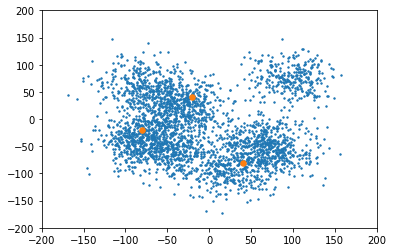

In [27]:
plt.scatter(position_df[:,0], position_df[:,1], s=2)
plt.scatter(station_pos[:,0], station_pos[:,1], s=30)
plt.xlim((-200,200))
plt.ylim((-200,200))
plt.show()